# Keras

## 1. Introduction

* High-Level library to build, train, and evaluate **Neural Networks** (**Deep Learning** models).
* Built-in data handling and preprocessing (i.e. image and text)
* Integration with different backends (**JAX**, **TensorFlow** or **PyTorch**).
* Various Neural Network architectures:
    * **Sequential Models**: Linear stacks of layers (most common for many standard deep learning tasks).
    * **Functional API**: More complex model (multi-input/multi-output, directed acyclic graphs DAGs or models with shared layers).
    * **Subclassing API**: Greater customization by implementing your own layers.
* Simple model interface:
    * `model = XXX()...` &rarr; `model.fit(X, y)` &rarr; `model.predict(X_new)` , `model.evaluate(X_new, y_new)`

### Neural Networks (Artificial Neural Networks)

* Fundamental tools in Machine Learning
* Consists of interconnected nodes (neurons) organized into layers.
* Each neuron:
    1. Receives input signals
    1. Performs a computation on them (tipically a sum)
    1. Applyes an (non linear) activation function
    1. Produces an output signal that may be passed to other neurons

<center><img src="img/neuron.png" alt="neuron" style="width: 90%;"/></center>

* **Input Layer**: Receives the raw input data. The number of neurons corresponds to the number of features in the data.
* **Hidden Layers**: One or more (*deep*) intermediate layers. They extract increasingly complex features.
* **Output Layer**: Produces the final prediction or classification. The number of neurons and the activation function in this layer depend on the task (1 for regression, N for classification)

<center><img src="img/mlp.jpeg" alt="mlp" style="width: 80%;"/></center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
mpl.rcParams['figure.figsize'] = (5.33,4)
mpl.rcParams['axes.labelsize'] = 10  # Example: 14 points
mpl.rcParams['xtick.labelsize'] = 8  # Example: 12 points for x-axis ticks
mpl.rcParams['ytick.labelsize'] = 8  # Example: 12 points for y-axis ticks

### Fashion MNIST

In [2]:
import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")
train_df = pd.read_csv(path + '/fashion-mnist_train.csv')
test_df = pd.read_csv(path + '/fashion-mnist_test.csv')

In [3]:
X_train = train_df.drop('label', axis=1).to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df.drop('label', axis=1).to_numpy()
y_test = test_df['label'].to_numpy()
print(f'{X_train.shape=}\n{y_train.shape=}')
print(f'{X_train.shape=}\n{y_train.shape=}')
print(f'{X_test.shape=}\n{y_test.shape=}')
print(f'{X_train.max()=}\n{X_train.min()=}')
print(f'{X_test.max()=}\n{X_test.min()=}')
print(f'{np.unique(y_train)}')

X_train.shape=(60000, 784)
y_train.shape=(60000,)
X_train.shape=(60000, 784)
y_train.shape=(60000,)
X_test.shape=(10000, 784)
y_test.shape=(10000,)
X_train.max()=255
X_train.min()=0
X_test.max()=255
X_test.min()=0
[0 1 2 3 4 5 6 7 8 9]


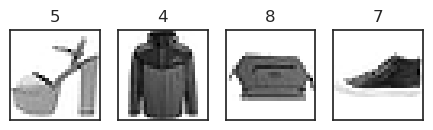

In [4]:
with sns.axes_style('white'):
    for i,idx in enumerate(np.random.randint(0,X_train.shape[0],4)):
        plt.subplot(1, 4, i+1)
        plt.imshow(X_train[idx].reshape(28,28), cmap=plt.cm.gray_r)
        plt.title(f'{y_train[idx]}')
        plt.xticks([]) 
        plt.yticks([]) 

In [5]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
# shuffle training data...
rindex = np.arange(X_train.shape[0])
np.random.shuffle(rindex)
X_train = X_train[rindex].copy()
y_train = y_train[rindex].copy()
print(f'{X_train.shape=}\n{y_train.shape=}')
print(f'{X_test.shape=}\n{y_test.shape=}')
print(f'{X_train.max()=}\n{X_train.min()=}')
print(f'{X_test.max()=}\n{X_test.min()=}')
print(f'{np.unique(y_train)}')

X_train.shape=(60000, 784)
y_train.shape=(60000,)
X_test.shape=(10000, 784)
y_test.shape=(10000,)
X_train.max()=1.0
X_train.min()=0.0
X_test.max()=1.0
X_test.min()=0.0
[0 1 2 3 4 5 6 7 8 9]


## 2. `Sequential` model

* Linear Stack of Layers
* The output (tensor) of a layer is the input (tensor) of the next layer
* `model = Sequential([ A(), B(), C()... ])`
* Core Layers:
    * `Input`. Often the first one, is a simple placeholder for the input tensor.
    * `Dense`. Fully Connected Layer ($~\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}$). Every neuron in the layer receives input (a weighted sum + offset) from all the neurons in the preceding layer.
    * `Activation` . Applies an activation function to the output of the preceding layer. Can often be specified directly within other layers
    * `Flatten` . Converts a multi-dimensional input tensor into a one-dimensional tensor.

### Activation Functions
* `sigmoid` . Outputs values between 0 and 1. Can suffer from vanishing gradients
$$f(x)=\frac{1}{1+e^{-x}}$$
* `tanh` (Hyperbolic Tangent): Similar to sigmoid but centered around zero. Can also suffer from vanishing gradients
$$f(x)=\frac{e^x - e^{-x}}{e^x + e^{-x}} = 2 \cdot sigmoid(2x) - 1$$
* `relu` (Rectified Linear Unit). Simple, efficient, and helps with the vanishing gradient problem. Can suffer from the "dying ReLU" problem (get stuck in the negative side).
$$f(x)=\max(0,x)$$
* `softmax` . Converts a vector of raw scores into a probability distribution over multiple classes. 
$$f(x)_i=\frac{e^{x_i}}{\sum_{j}e^{-x_j}}$$

<center><img src="img/relu-tanh-sigmoid.png" alt="relu tanh sigmoid" style="width: 90%;"/></center>

An example sequential model for fmnist data:

In [6]:
#Configuration of Keras backend (JAX) using only CPU
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["JAX_PLATFORMS"] = "cpu"

In [7]:
from keras import Sequential
from keras.layers import Input, Dense, Activation

model = Sequential([
        Input(shape=(784,)),
        Dense(512),
        Activation('sigmoid'),
        Dense(128),
        Activation('tanh'),
        Dense(32),
        Activation('relu'),
        Dense(10),
        Activation('softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,042 (1.80 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Activations can often be specified directly within other layers:

In [8]:
model = Sequential([
        Input(shape=(784,)),
        Dense(512, activation='sigmoid'),
        Dense(128, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,042 (1.80 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
input_shape = X_train[0].shape
num_classes = np.unique(y_train).size
print(f'{input_shape =}\n{num_classes = }')

model = Sequential([
        Input(shape=input_shape),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(num_classes, activation="softmax")
])
model.summary()

input_shape =(784,)
num_classes = 10


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,042 (1.80 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

 Configure the learning process of the neural networkbefore training it:

In [10]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Accuracy

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

If we are using the default arguments, many parameters can be set with their correspondent names: 

In [11]:
print(f'{Adam().name = }')
print(f'{SparseCategoricalCrossentropy().name = }')

Adam().name = 'adam'
SparseCategoricalCrossentropy().name = 'sparse_categorical_crossentropy'


In [12]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Fit the model and get a callback that records events that happen during the training process:

In [13]:
callback = model.fit(X_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7730 - loss: 0.6492 - val_accuracy: 0.8405 - val_loss: 0.4306
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8587 - loss: 0.3845 - val_accuracy: 0.8696 - val_loss: 0.3578
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8724 - loss: 0.3495 - val_accuracy: 0.8781 - val_loss: 0.3323
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8804 - loss: 0.3192 - val_accuracy: 0.8863 - val_loss: 0.3161
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8903 - loss: 0.2988 - val_accuracy: 0.8842 - val_loss: 0.3237
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8955 - loss: 0.2841 - val_accuracy: 0.8913 - val_loss: 0.3062
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8990 - loss: 0.2706 - val_accuracy: 0.8798 - val_loss: 0.3240
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9033 - loss: 0.2578 - 

`callback.history` contains a dictionary with the losses and metrics for each epoch:

In [14]:
callback.history

{'accuracy': [0.8171666860580444,
  0.8606041669845581,
  0.8730624914169312,
  0.8818541765213013,
  0.8890833258628845,
  0.893708348274231,
  0.8989999890327454,
  0.9024375081062317,
  0.9065208435058594,
  0.9096458554267883],
 'loss': [0.5117257237434387,
  0.37997451424598694,
  0.34792351722717285,
  0.3206142485141754,
  0.30075812339782715,
  0.28705742955207825,
  0.2732927203178406,
  0.26102137565612793,
  0.24958518147468567,
  0.23922961950302124],
 'val_accuracy': [0.840499997138977,
  0.8695833086967468,
  0.878083348274231,
  0.8862500190734863,
  0.8842499852180481,
  0.8912500143051147,
  0.8797500133514404,
  0.8878333568572998,
  0.887583315372467,
  0.8961666822433472],
 'val_loss': [0.4305688142776489,
  0.3577728271484375,
  0.332341730594635,
  0.31607750058174133,
  0.3237145245075226,
  0.30622008442878723,
  0.3240238130092621,
  0.3120673894882202,
  0.32815074920654297,
  0.29852965474128723]}

In [15]:
hist = pd.DataFrame(callback.history)
hist.head()

,accuracy,loss,val_accuracy,val_loss
0,0.817167,0.511726,0.840500,0.430569
1,0.860604,0.379975,0.869583,0.357773
2,0.873062,0.347924,0.878083,0.332342
3,0.881854,0.320614,0.886250,0.316078
4,0.889083,0.300758,0.884250,0.323715


In [16]:
hist = pd.DataFrame(callback.history)
hist.index += 1
hist.index.name = 'epoch'
hist.head()

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
1,0.817167,0.511726,0.840500,0.430569
2,0.860604,0.379975,0.869583,0.357773
3,0.873062,0.347924,0.878083,0.332342
4,0.881854,0.320614,0.886250,0.316078
5,0.889083,0.300758,0.884250,0.323715


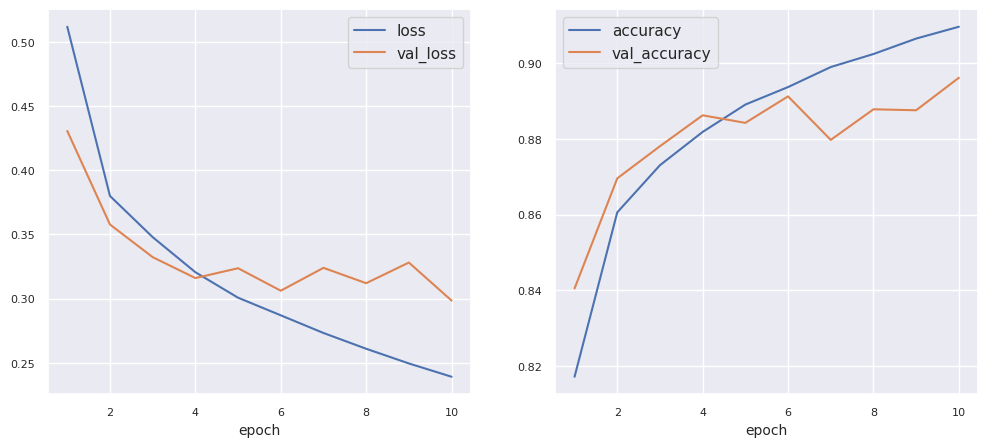

In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist[['loss','val_loss']].plot(ax=ax1)
hist[['accuracy','val_accuracy']].plot(ax=ax2);

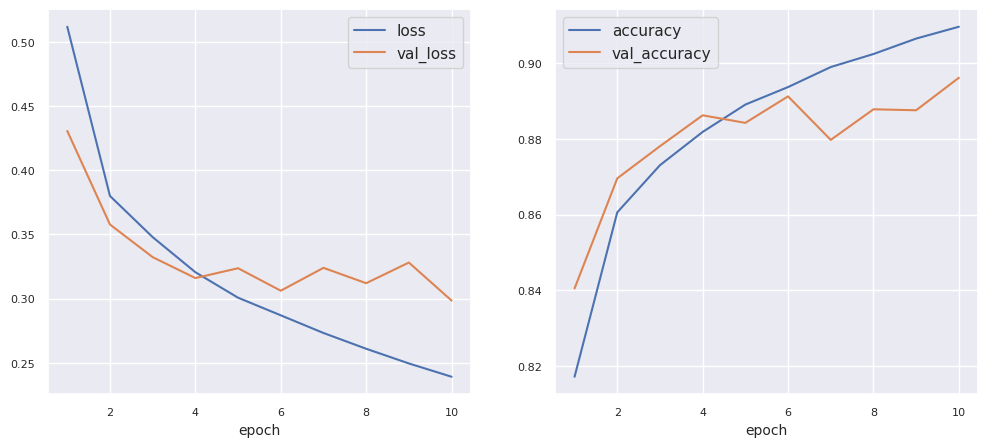

In [18]:
def plot_callback(callback):
    hist = pd.DataFrame(callback.history)
    hist.index += 1
    hist.index.name = 'epoch'
    hist.head()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
    hist[['loss','val_loss']].plot(ax=ax1)
    hist[['accuracy','val_accuracy']].plot(ax=ax2)

plot_callback(callback)

Increasing the complexity of the model (more neurons per layer and more layers) or training too much epoch could lead to overfitting. Running 80 epochs:

<center><img src="img/80epochs.png" alt="80 epochs" style="width: 90%;"/></center>

### Regularizations

* **Weight Regularization**: Adds a penalty to the loss function based on the weights. Tends to sparsity in the weights.
    * L1 (Lasso), L2 (Ridge) or L1L2 (Elastic Net)
* **Activity Regularization**: Adds a penalty to the loss function based on the activations of a layer.
* **Dropout**: Randomly sets a fraction of the input units to 0 (during training). Encourages the network to learn more robust representations
* **Batch Normalization**: Normalizes the activations of a layer across the batch. Improves training stability and speed.
* **Early Stopping**: Stops the training process when the validation performance starts to degrade. Prevents overfitting


In [19]:
from keras.layers import Dropout

input_shape = X_train[0].shape
num_classes = np.unique(y_train).size
print(f'{input_shape =}\n{num_classes = }')

model = Sequential([
        Input(shape=input_shape),
        Dense(512, activation="relu"),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.4),
        Dense(32, activation="relu"),
        Dropout(0.4),
        Dense(num_classes, activation="softmax")
])
model.summary()

input_shape =(784,)
num_classes = 10


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,042 (1.80 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
callback = model.fit(X_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5724 - loss: 1.1795 - val_accuracy: 0.8104 - val_loss: 0.4898
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7786 - loss: 0.6186 - val_accuracy: 0.8393 - val_loss: 0.4366
Epoch 3/10
1062/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8146 - loss: 0.5445

Fit the model and get a callback that records events that happen during the training process:

In [ ]:
plot_callback(callback)

Running 80 epochs:

<center><img src="img/80epochs-dropout.png" alt="80 epochs + dropout" style="width: 90%;"/></center>

## 3. Convolutional Neural Network CNN

* Work on two (or more) dimensional data
* **Convolutional Layer**
    * Each neuron is conectet to a small, local region (neurons) of the previous layer through a **filter** (kernel).
    * Filters slide across the input data, performing element-wise multiplication and summing the results.
    * Each filter learns to identify a particular **pattern**
    * **Few parameters**: The same filter is used across the entire input map
* **Pooling Layer**
    * Reduces the size using aggregation functions (max, average...)
 
<center><img src="img/cnn.webp" alt="80 epochs" style="width: 90%;"/></center>

`Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs`

* `filters: int` &rarr; number of filters
* `kernel_size: int or tuple/list of 2 integer` &rarr; size of the convolution window.
* `strides: int or tuple/list of 2 integer` &rarr; displacement (step size) of the kernel as it moves across the input.
* `padding: string, either "valid" or "same"` &rarr; controls how the input tensor is padded with zeros (`"valid"` means no padding). When `padding="same"` and `strides=1`, the output has the same size as the input.

### Pooling layers
* **Local Pooling**: uses a `pool_size` similar to Conv2D kernel_size.
    * Keeps the number of dimensions of the data
    * Purpose: downsampling, translation invariance
    * **MaxPooling2D**, **AveragePooling2D**
* **Local Pooling**: aplied over the entire spatial dimension (width/height)
    * Reduces the number of dimensions of the data (with/height are collapsed)
    * Purpose: global feature aggregation, Convolutional to Dense layers adptation
    * **GlobalMaxPooling2D**, **GlobalAveragePooling2D**

### Data preparation

In [ ]:
from math import isqrt
new_dim = isqrt(X_train.shape[1])
X_train = X_train.reshape((X_train.shape[0],new_dim,new_dim))
X_test = X_test.reshape((X_test.shape[0],new_dim,new_dim))
print(f'{X_train.shape=}\n{y_train.shape=}')
print(f'{X_test.shape=}\n{y_test.shape=}')
with sns.axes_style('white'):
    for i,idx in enumerate(np.random.randint(0,X_train.shape[0],4)):
        plt.subplot(1, 4, i+1)
        plt.imshow(X_train[idx], cmap=plt.cm.gray_r)
        plt.title(f'{y_train[idx]}')
        plt.xticks([]) 
        plt.yticks([]) 

**Note**: We could have imported the data directly from keras.datasets, with the correct shapes:
* `X_train.shape=(60000, 28, 28)`
* `X_test.shape=(10000, 28, 28)`

In [ ]:
#from keras.datasets import fashion_mnist
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Defining the Model Architecture

We will use some default parameters:

* **Conv2D** &rarr; `strides=1` , padding='valid'
* **MaxPooling2D** &rarr; `strides=None` (equal to `pool_size`)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

input_shape = *X_train[0].shape,1
num_classes = np.unique(y_train).size
print(f'{input_shape =}\n{num_classes = }')

model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        GlobalAveragePooling2D(),

        Dense(256, activation="relu"),
        Dense(num_classes, activation="softmax")
])
model.summary()

This is gona be very slow on CPU, so just run 1 epoch...

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
callback = model.fit(X_train, y_train, validation_split=0.2, epochs=1)

In [ ]:
#plot_callback(callback)

How can we speed up execution:
1. Download the notebook & upload it to [Google Colab](https://colab.research.google.com/)
1. Change the line to `os.environ["JAX_PLATFORMS"] = ""`
1. Increase the number of epochs
1. Connect to a **GPU** instance
1. Run it!!!

Result for 40 epochs:

<center><img src="img/cnn1-gpu.png" alt="cnn1-gpu" style="width: 90%;"/></center>

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

input_shape = *X_train[0].shape,1
num_classes = np.unique(y_train).size
print(f'{input_shape =}\n{num_classes = }')

conv2d_args = {'kernel_size':(3, 3), 'activation':'relu', 'strides':1, 'padding':'same'}
maxp2d_args = {'pool_size':(2, 2), 'padding':'valid', 'strides':2}
model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, **conv2d_args),
        BatchNormalization(),
        Conv2D(32, **conv2d_args),
        BatchNormalization(),
        MaxPooling2D(**maxp2d_args),
        Dropout(0.25),

        Conv2D(64, **conv2d_args),
        BatchNormalization(),
        Conv2D(64, **conv2d_args),
        BatchNormalization(),
        MaxPooling2D(**maxp2d_args),
        Dropout(0.25),

        Conv2D(128, **conv2d_args),
        BatchNormalization(),
        Conv2D(128, **conv2d_args),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.25),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
        Dense(num_classes, activation='softmax'),
])        

model.summary()

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
callback = model.fit(X_train, y_train, validation_split=0.2, epochs=1)

In [ ]:
#plot_callback(callback)

Result for 40 epochs:

<center><img src="img/cnn2-gpu.png" alt="cnn2-gpu" style="width: 90%;"/></center>